# Fully connected feedforward network implementing a loss mask

In [1]:
import sys
sys.path.insert(0,'../')
import torch
import torchmetrics.classification
from torch import cuda
from maldi2resistance.model.MultilabelResMLP import MultilabelResMLP
from src.maldi2resistance.data.driams import Driams
assert cuda.is_available()
assert cuda.device_count() > 0
print(cuda.get_device_name(cuda.current_device()))

NVIDIA RTX 2000 Ada Generation Laptop GPU


In [2]:
All_antibiotics = ["5-Fluorocytosine"
,"Amikacin"
,"Aminoglycosides"
,"Amoxicillin"
,"Amoxicillin-Clavulanic acid"
,"Amoxicillin-Clavulanic acid_uncomplicated_HWI"
,"Amoxicillin+Clavulanic acid"
,"AmphotericinB"
,"Ampicillin"
,"Ampicillin-Amoxicillin"
,"Ampicillin-Sulbactam"
,"Ampicillin+Sulbactam"
,"Anidulafungin"
,"Azithromycin"
,"Aztreonam"
,"Bacitracin"
,"Benzylpenicillin"
,"Benzylpenicillin_others"
,"Benzylpenicillin_with_meningitis"
,"Benzylpenicillin_with_pneumonia"
,"Caspofungin"
,"Cefalotin-Cefazolin"
,"Cefazolin"
,"Cefepime"
,"Cefixime"
,"Cefotaxim"
,"Cefotaxime"
,"Cefoxitin"
,"Cefoxitin_screen"
,"Cefpodoxime"
,"Ceftarolin"
,"Ceftazidime"
,"Ceftazidime-Avibactam"
,"Ceftobiprole"
,"Ceftolozane-Tazobactam"
,"Ceftriaxone"
,"Cefuroxime"
,"Chloramphenicol"
,"Ciprofloxacin"
,"Clarithromycin"
,"Clindamycin"
,"Colistin"
,"Cotrimoxazol"
,"Cotrimoxazole"
,"Daptomycin"
,"Doxycycline"
,"Ertapenem"
,"Erythromycin"
,"Fluconazol"
,"Fluconazole"
,"Fosfomycin"
,"Fosfomycin-Trometamol"
,"Fusidic acid"
,"Gentamicin"
,"Gentamicin_high_level"
,"Imipenem"
,"Isavuconazole"
,"Itraconazole"
,"Levofloxacin"
,"Linezolid"
,"Meropenem"
,"Meropenem_with_meningitis"
,"Meropenem_without_meningitis"
,"Metronidazole"
,"Micafungin"
,"Minocycline"
,"Moxifloxacin"
,"Mupirocin"
,"Neomycin"
,"Nitrofurantoin"
,"Norfloxacin"
,"Novobiocin"
,"Oxacillin"
,"Penicillin"
,"Penicillin_with_endokarditis"
,"Penicillin_with_meningitis"
,"Penicillin_with_other_infections"
,"Penicillin_with_pneumonia"
,"Penicillin_without_endokarditis"
,"PenicillinG"
,"Piperacillin"
,"Piperacillin-Tazobactam"
,"Polymyxin B"
,"Posaconazole"
,"Quinolones"
,"Rifampicin"
,"Rifampicin_1mg-l"
,"Strepomycin_high_level"
,"Teicoplanin"
,"Teicoplanin_GRD"
,"Tetracycline"
,"Ticarcillin"
,"Ticarcillin-Clavulan acid"
,"Tigecycline"
,"Tobramycin"
,"Vancomycin"
,"Voriconazole"]

### Load the Dataset

In [3]:
driams = Driams(
    root_dir="/home/youngjunpark/MS_data",
    sites=["DRIAMS-A"],
    #years=[2020,2021],
    cutoff_value=1,
    cutoff_value_positive=1,
    cutoff_value_negative=1,
    antibiotics=All_antibiotics,
)

driams.loading_type = "memory"

driams.label_stats.to_csv('driams_a_test.stat')

Loading Spectra into Memory:   0%|          | 0/38331 [00:00<?, ?it/s]

# Load done

In [4]:
DEVICE = torch.device("cuda")
SEED = 76436278

torch.manual_seed(SEED)

len(driams.selected_antibiotics)

97

In [5]:
from maldi2resistance.model.MLP import AeBasedMLP
LATENT_SIZE = 256
#model = AeBasedMLP(input_dim=18000, output_dim = len(driams.selected_antibiotics))
model = MultilabelResMLP(input_dim=18000, output_dim=len(driams.selected_antibiotics), hidden_dim=LATENT_SIZE)
model.to(DEVICE)

MultilabelResMLP(
  (first): Linear(in_features=18000, out_features=256, bias=True)
  (res_mlp): ResMLP(
    (net): Sequential(
      (0): ResBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Linear(in_features=256, out_features=256, bias=True)
          (2): Dropout(p=0.2, inplace=False)
          (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ResBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Linear(in_features=256, out_features=256, bias=True)
          (2): Dropout(p=0.2, inplace=False)
          (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): ResBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Linear(in_features=256, out_features=256, bias=True)
          (2): Dropout(p=0.2, inplace=False)
          (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [6]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(driams, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory= True)

In [7]:
from maldi2resistance.loss.maskedLoss import MaskedBCE
from tqdm.auto import tqdm

from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

print("Start training ...")
model.train()

optimizer = Adam(model.parameters(), lr=1e-3, amsgrad = True)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
loss_per_batch = []

class_weights_negative = torch.tensor((1 - (driams.label_stats.loc["negative"] / driams.label_stats.loc["n_sum"])).values, device=DEVICE)
class_weights_positive = torch.tensor((1 - (driams.label_stats.loc["positive"] / driams.label_stats.loc["n_sum"])).values, device=DEVICE)

criterion = MaskedBCE(class_weights_positive= class_weights_negative, class_weights_negative= class_weights_negative)

for epoch in tqdm(range(40)):
    overall_loss = 0
    
    for batch_idx, (x, y) in enumerate(train_loader):
        
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        
        optimizer.zero_grad()

        output = model(x)

        loss = criterion(output, y)
        current_loss_value = loss.item()
        loss_per_batch.append(current_loss_value)
        
        overall_loss += current_loss_value
        
        loss.backward()
        optimizer.step()

    scheduler.step()
    with tqdm.external_write_mode():
        print(f"\tAverage Loss: {overall_loss / (batch_idx*batch_size):.6f} \tLearning rate: {scheduler.get_last_lr()[0]:.6f}")


print("Finish")

Start training ...


  0%|          | 0/40 [00:00<?, ?it/s]

	Average Loss: 0.000122 	Learning rate: 0.001000
	Average Loss: 0.000099 	Learning rate: 0.001000
	Average Loss: 0.000092 	Learning rate: 0.001000
	Average Loss: 0.000087 	Learning rate: 0.001000
	Average Loss: 0.000083 	Learning rate: 0.001000
	Average Loss: 0.000079 	Learning rate: 0.001000
	Average Loss: 0.000076 	Learning rate: 0.001000
	Average Loss: 0.000073 	Learning rate: 0.001000
	Average Loss: 0.000069 	Learning rate: 0.001000
	Average Loss: 0.000067 	Learning rate: 0.000500
	Average Loss: 0.000060 	Learning rate: 0.000500
	Average Loss: 0.000058 	Learning rate: 0.000500
	Average Loss: 0.000056 	Learning rate: 0.000500
	Average Loss: 0.000054 	Learning rate: 0.000500
	Average Loss: 0.000052 	Learning rate: 0.000500
	Average Loss: 0.000051 	Learning rate: 0.000500
	Average Loss: 0.000050 	Learning rate: 0.000500
	Average Loss: 0.000049 	Learning rate: 0.000500
	Average Loss: 0.000048 	Learning rate: 0.000500
	Average Loss: 0.000046 	Learning rate: 0.000250
	Average Loss: 0.000

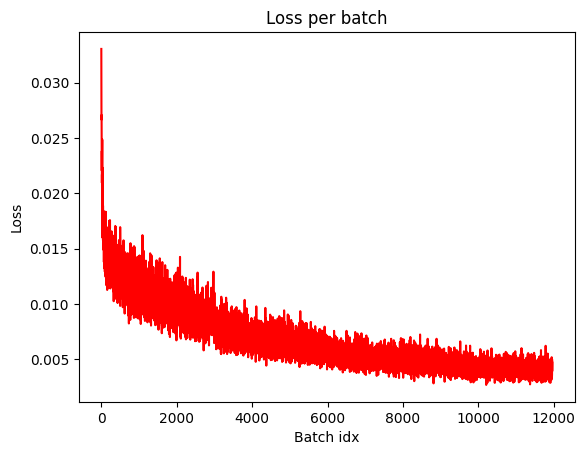

In [8]:
import matplotlib.pyplot as plt 

plt.title("Loss per batch") 
plt.xlabel("Batch idx") 
plt.ylabel("Loss") 
plt.plot(list(range(0,len(loss_per_batch))),loss_per_batch , color ="red") 
plt.show()

In [9]:
model.eval()

MultilabelResMLP(
  (first): Linear(in_features=18000, out_features=256, bias=True)
  (res_mlp): ResMLP(
    (net): Sequential(
      (0): ResBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Linear(in_features=256, out_features=256, bias=True)
          (2): Dropout(p=0.2, inplace=False)
          (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ResBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Linear(in_features=256, out_features=256, bias=True)
          (2): Dropout(p=0.2, inplace=False)
          (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): ResBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Linear(in_features=256, out_features=256, bias=True)
          (2): Dropout(p=0.2, inplace=False)
          (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [10]:
torch.save({
            'model_state_dict': model.state_dict(),
            'selected_antibiotics': driams.selected_antibiotics
            }, f'./DRIAMS_model_97_antibiotics_seed_{SEED}.pt')

# Eval

In [32]:
import math
from pathlib import Path
import matplotlib.style
import matplotlib as mpl
import torch

DEVICE = torch.device("cuda")

torch.manual_seed(SEED)
mpl.style.use("default")

checkpoint = torch.load(f'./DRIAMS_model_97_antibiotics_seed_{SEED}.pt')

site = ["DRIAMS-D"]

path = Path(f"./train_on_DRIAMS-A/{site[0]}_{SEED}-results/")
path.mkdir(parents=True, exist_ok=True)

/tmp/ipykernel_109821/263783473.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'./DRIAMS_model_97_antibiotics_seed_{SEED}.pt')


In [33]:
from src.maldi2resistance.data.driams import Driams

driams = Driams(
    root_dir="/home/youngjunpark/MS_data",
    sites=site,
    #years=[2020,2021],
    antibiotics= All_antibiotics,
    cutoff_value= 1,
    cutoff_value_negative= 1,
    cutoff_value_positive= 1
)

driams.loading_type = "memory"

driams.label_stats

/home/youngjunpark/Git/my_maldi/maldi2resistance/preTraining/../src/maldi2resistance/data/driams.py:86: UserWarning: Metafile for Site (DRIAMS-D) and Year (2015) combination not found!
  warnings.warn(
/home/youngjunpark/Git/my_maldi/maldi2resistance/preTraining/../src/maldi2resistance/data/driams.py:86: UserWarning: Metafile for Site (DRIAMS-D) and Year (2016) combination not found!
  warnings.warn(
/home/youngjunpark/Git/my_maldi/maldi2resistance/preTraining/../src/maldi2resistance/data/driams.py:86: UserWarning: Metafile for Site (DRIAMS-D) and Year (2017) combination not found!
  warnings.warn(


Loading Spectra into Memory:   0%|          | 0/10369 [00:00<?, ?it/s]

,5-Fluorocytosine,Amikacin,Aminoglycosides,Amoxicillin,Amoxicillin+Clavulanic acid,Amoxicillin-Clavulanic acid,Amoxicillin-Clavulanic acid_uncomplicated_HWI,AmphotericinB,Ampicillin,Ampicillin+Sulbactam,...,Strepomycin_high_level,Teicoplanin,Teicoplanin_GRD,Tetracycline,Ticarcillin,Ticarcillin-Clavulan acid,Tigecycline,Tobramycin,Vancomycin,Voriconazole
positive,0,34,0,0,0,1516,0,0,4840,0,...,0,8,0,299,161,104,2,12,17,0
negative,0,1981,0,0,0,5080,0,0,2037,0,...,0,279,0,2747,68,131,3066,313,3314,0
n_sum,0,2015,0,0,0,6596,0,0,6877,0,...,0,287,0,3046,229,235,3068,325,3331,0


In [34]:
from maldi2resistance.model.MLP import AeBasedMLP

model = MultilabelResMLP(input_dim=18000, output_dim=len(driams.selected_antibiotics), hidden_dim=LATENT_SIZE)
model.to(DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])

#model.eval()

<All keys matched successfully>

In [35]:
from torch.utils.data import DataLoader

test_size = len(driams)
test_loader = DataLoader(driams, batch_size= test_size, shuffle=True)
test_features, test_labels = next(iter(test_loader))

In [36]:
test_features = test_features.view(test_size, 18000)
test_features = test_features.to(DEVICE)

test_labels = test_labels.view(test_size, len(driams.selected_antibiotics))
test_labels = test_labels.to(DEVICE)

output = model(test_features)

/home/youngjunpark/miniconda3/envs/py311/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/youngjunpark/miniconda3/envs/py311/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


(0.8244659900665283, 0.5767971064363208)


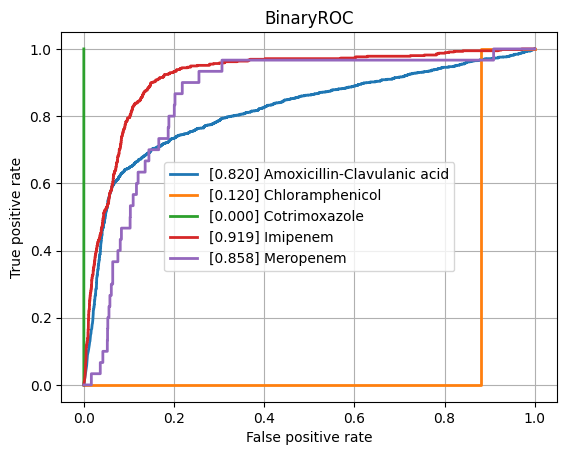

In [37]:
from matplotlib import pyplot as plt
from maldi2resistance.metric.ROC import MultiLabelRocNan

ml_roc = MultiLabelRocNan()
print(ml_roc.compute(output,test_labels,driams.selected_antibiotics, create_csv=path /"ROC_results.csv"))
fig_, ax_ = ml_roc()

plt.savefig(path / "ROC.png", transparent=True, format= "png", bbox_inches = "tight")
plt.show()

(0.45979976654052734, 0.26974542040775035)


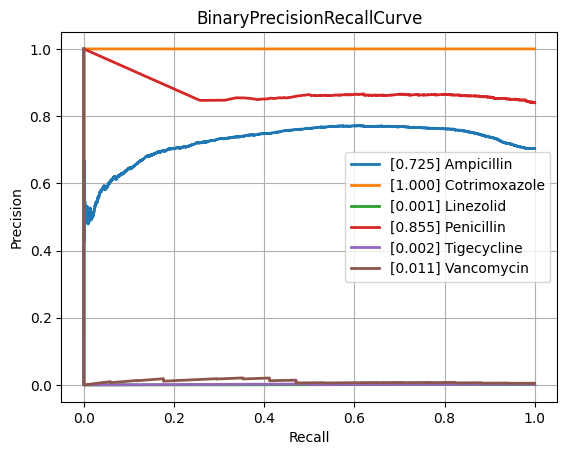

In [38]:
from maldi2resistance.metric.PrecisionRecall import MultiLabelPRNan
import matplotlib.pyplot as plt

ml_pr = MultiLabelPRNan()
print(ml_pr.compute(output,test_labels,driams.selected_antibiotics, create_csv=path / "PR_results.csv"))

fig_, ax_ = ml_pr()

plt.savefig(path / "PrecisionRecall.png", transparent=True, format= "png", bbox_inches = "tight")
plt.show()